<a href="https://colab.research.google.com/github/shu-nya/Image-Classification-of-White-Blood-Cells/blob/master/WB_Classification_augmentation_and_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.models import Sequential
from keras import applications
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
import csv
import cv2
import scipy
import os
from PIL import Image
#import splitfolders
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_DIR = '/content/drive/MyDrive/taskMedPrime'

In [5]:
num_classes = 9


In [6]:
classes = ['bands', 'basophils', 'blasts', 'eosinophils', 'lymphocytes', 'metamyelocytes', 'monocytes', 'myelocytes', 'neutrophils']

for i in classes:

    os.makedirs(BASE_DIR + '/train/' + i)

    os.makedirs(BASE_DIR + '/test/' + i)

    source = BASE_DIR + '/wbc/' + i

    allFileNames = os.listdir(source)

    np.random.shuffle(allFileNames)

    test_ratio = 0.20

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [source + '/' + name for name in train_FileNames.tolist()]
    test_FileNames = [source + '/' + name for name in test_FileNames.tolist()]


    for name in train_FileNames:
        shutil.copy(name, BASE_DIR +'/train/' + i)

    for name in test_FileNames:
        shutil.copy(name, BASE_DIR +'/test/' + i)

In [7]:
def get_data(folder):
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):

            for image_filename in os.listdir(folder + '/' + wbc_type):
                img_file = cv2.imread(folder + '/' + wbc_type + '/' + image_filename)

                if img_file is not None:
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(wbc_type)

    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [8]:
X_train, y_train = get_data(BASE_DIR + '/train')
X_test, y_test = get_data(BASE_DIR + '/test')

X_train = X_train * 1./255.
X_test = X_test * 1./255.

In [9]:
basophils_samples = X_train[np.where(y_train == 'basophils')]
bands_samples = X_train[np.where(y_train == 'bands')]
blasts_samples = X_train[np.where(y_train == 'blasts')]
metamyelocytes_samples = X_train[np.where(y_train == 'metamyelocytes')]
myelocytes_samples = X_train[np.where(y_train == 'myelocytes')]


eosinophils_samples = X_train[np.where(y_train == 'eosinophils')]
lymphocytes_samples = X_train[np.where(y_train == 'lymphocytes')]
monocytes_samples = X_train[np.where(y_train == 'monocytes')]
neutrophils_samples = X_train[np.where(y_train == 'neutrophils')]


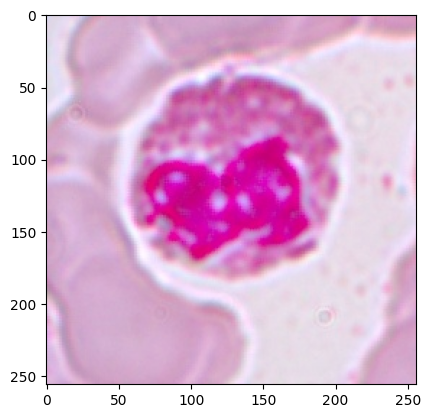

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

len(eosinophils_samples)
plt.imshow((eosinophils_samples[5])/(127.5 - 1))
plt.imshow((eosinophils_samples[5]))

In [11]:
datagen = ImageDataGenerator(
    rotation_range=20,
    fill_mode='constant',
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2
)

In [12]:
basophils_generator = datagen.flow(
        basophils_samples,
        y_train[np.where(y_train == 'basophils')],
        save_to_dir = BASE_DIR + '/train/basophils',
        batch_size=1)

bands_generator = datagen.flow(
        bands_samples,
        y_train[np.where(y_train == 'bands')],
        save_to_dir = BASE_DIR + '/train/bands',
        batch_size=1)

blasts_generator = datagen.flow(
        blasts_samples,
        y_train[np.where(y_train == 'blasts')],
        save_to_dir = BASE_DIR + '/train/blasts',
        batch_size=1)

metamyelocytes_generator = datagen.flow(
        metamyelocytes_samples,
        y_train[np.where(y_train == 'metamyelocytes')],
        save_to_dir = BASE_DIR + '/train/metamyelocytes',
        batch_size=1)

myelocytes_generator = datagen.flow(
        myelocytes_samples,
        y_train[np.where(y_train == 'myelocytes')],
        save_to_dir = BASE_DIR + '/train/myelocytes',
        batch_size=1)



eosinophils_generator = datagen.flow(
        eosinophils_samples,
        y_train[np.where(y_train == 'eosinophils')],
        save_to_dir = BASE_DIR + '/train/eosinophils',
        batch_size=1)

lymphocytes_generator = datagen.flow(
        lymphocytes_samples,
        y_train[np.where(y_train == 'lymphocytes')],
        save_to_dir = BASE_DIR + '/train/lymphocytes',
        batch_size=1)

monocytes_generator = datagen.flow(
        monocytes_samples,
        y_train[np.where(y_train == 'monocytes')],
        save_to_dir = BASE_DIR + '/train/monocytes',
        batch_size=1)

neutrophils_generator = datagen.flow(
        neutrophils_samples,
        y_train[np.where(y_train == 'neutrophils')],
        save_to_dir = BASE_DIR + '/train/neutrophils',
        batch_size=1)

In [13]:
datagen_simple = ImageDataGenerator()

In [14]:
for i in range(250):
    next(basophils_generator)
    next(bands_generator)
    next(blasts_generator)
    next(metamyelocytes_generator)
    next(myelocytes_generator)


    next(eosinophils_generator)
    next(lymphocytes_generator)
    next(monocytes_generator)
    next(neutrophils_generator)

In [15]:
basophils_test_samples = X_test[np.where(y_test == 'basophils')]
bands_test_samples = X_test[np.where(y_test == 'bands')]
blasts_test_samples = X_test[np.where(y_test == 'blasts')]
metamyelocytes_test_samples = X_test[np.where(y_test == 'metamyelocytes')]
myelocytes_test_samples = X_test[np.where(y_test == 'myelocytes')]


eosinophils_test_samples = X_test[np.where(y_test == 'eosinophils')]
lymphocytes_test_samples = X_test[np.where(y_test == 'lymphocytes')]
monocytes_test_samples = X_test[np.where(y_test == 'monocytes')]
neutrophils_test_samples = X_test[np.where(y_test == 'neutrophils')]

In [16]:
basophils_test_generator = datagen_simple.flow(
        basophils_test_samples,
        y_test[np.where(y_test == 'basophils')],
        save_to_dir = BASE_DIR + '/test/basophils',
        batch_size=1)

bands_test_generator = datagen_simple.flow(
        bands_test_samples,
        y_test[np.where(y_test == 'bands')],
        save_to_dir = BASE_DIR + '/test/bands',
        batch_size=1)

blasts_test_generator = datagen_simple.flow(
        blasts_test_samples,
        y_test[np.where(y_test == 'blasts')],
        save_to_dir = BASE_DIR + '/test/blasts',
        batch_size=1)

metamyelocytes_test_generator = datagen_simple.flow(
        metamyelocytes_test_samples,
        y_test[np.where(y_test == 'metamyelocytes')],
        save_to_dir = BASE_DIR + '/test/metamyelocytes',
        batch_size=1)

myelocytes_test_generator = datagen_simple.flow(
        myelocytes_test_samples,
        y_test[np.where(y_test == 'myelocytes')],
        save_to_dir = BASE_DIR + '/test/myelocytes',
        batch_size=1)


eosinophils_test_generator = datagen_simple.flow(
        eosinophils_test_samples,
        y_test[np.where(y_test == 'eosinophils')],
        save_to_dir = BASE_DIR + '/test/eosinophils',
        batch_size=1)

lymphocytes_test_generator = datagen_simple.flow(
        lymphocytes_test_samples,
        y_test[np.where(y_test == 'lymphocytes')],
        save_to_dir = BASE_DIR + '/test/lymphocytes',
        batch_size=1)

monocytes_test_generator = datagen_simple.flow(
        monocytes_test_samples,
        y_test[np.where(y_test == 'monocytes')],
        save_to_dir = BASE_DIR + '/test/monocytes',
        batch_size=1)

neutrophils_test_generator = datagen_simple.flow(
        neutrophils_test_samples,
        y_test[np.where(y_test == 'neutrophils')],
        save_to_dir = BASE_DIR + '/test/neutrophils',
        batch_size=1)

In [17]:
for i in range(len(basophils_test_samples)):
    next(basophils_test_generator)
for i in range(len(bands_test_samples)):
    next(bands_test_generator)
for i in range(len(blasts_test_samples)):
    next(blasts_test_generator)
for i in range(len(metamyelocytes_test_samples)):
    next(metamyelocytes_test_generator)
for i in range(len(myelocytes_test_samples)):
    next(myelocytes_test_generator)


for i in range(len(eosinophils_test_samples)):
    next(eosinophils_test_generator)
for i in range(len(lymphocytes_test_samples)):
    next(lymphocytes_test_generator)
for i in range(len(monocytes_test_samples)):
    next(monocytes_test_generator)
for i in range(len(neutrophils_test_samples)):
    next(neutrophils_test_generator)

In [18]:
#Convert labels to one hot encoding

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)


In [ ]:
print(len(X_train))

In [ ]:
print(len(y_train))

In [19]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(256, 256, 3), output_shape=(256, 256, 3)))

    # layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(256, 356, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # layer 2
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.40))

    # layer 3
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.40))


    # Fully connected network layer
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.40))

    # Output
    model.add(Dense(9))
    model.add(Activation('softmax'))

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model

In [20]:
epochs = 20

batch_size = 32

In [21]:
model = get_model()

# fits the model on batches
estimator = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=150,
    shuffle=True,
    batch_size=32,
    verbose=2)

model.save_weights('balanced_model_2.h5')

Epoch 1/150
12/12 - 14s - loss: 5.4621 - accuracy: 0.2116 - val_loss: 2.1609 - val_accuracy: 0.0000e+00 - 14s/epoch - 1s/step
Epoch 2/150
12/12 - 1s - loss: 1.9149 - accuracy: 0.2302 - val_loss: 1.5519 - val_accuracy: 0.0000e+00 - 1s/epoch - 98ms/step
Epoch 3/150
12/12 - 1s - loss: 1.7295 - accuracy: 0.3810 - val_loss: 1.9117 - val_accuracy: 0.0000e+00 - 1s/epoch - 97ms/step
Epoch 4/150
12/12 - 1s - loss: 1.6965 - accuracy: 0.3862 - val_loss: 1.9472 - val_accuracy: 0.0000e+00 - 1s/epoch - 95ms/step
Epoch 5/150
12/12 - 1s - loss: 1.6835 - accuracy: 0.3836 - val_loss: 2.0326 - val_accuracy: 0.0000e+00 - 1s/epoch - 89ms/step
Epoch 6/150
12/12 - 1s - loss: 1.6407 - accuracy: 0.3783 - val_loss: 1.6409 - val_accuracy: 0.0000e+00 - 1s/epoch - 90ms/step
Epoch 7/150
12/12 - 1s - loss: 1.6637 - accuracy: 0.3519 - val_loss: 2.0343 - val_accuracy: 1.0000 - 1s/epoch - 89ms/step
Epoch 8/150
12/12 - 1s - loss: 1.6849 - accuracy: 0.3598 - val_loss: 1.8887 - val_accuracy: 0.0000e+00 - 1s/epoch - 91ms/s

In [22]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')

y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
4/4 [==============================] - 0s 18ms/step
0.0


In [23]:
from sklearn.metrics import confusion_matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)

y_test_unencoded = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))

[[ 6  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0]
 [38  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0]
 [42  0  0  0  0  0  0  0  0]]
